#  TP 3: 

### 14 avril 2024

### Par Samuel Fortin, Philippe Truchon et Benjamin Trudel

## TP3.1 Mécanique céleste - la Terre

### a)

Utilisez la m´ethode de Verlet pour calculer l’orbite de la Terre autour du soleil, consid´erant
que le mouvement est d´ecrit par

$\frac{d^2r}{dt^2} = -GM \frac{r}{r^3}$

et sachant que la distance du périhélie est de 1.4710×1011 m et que la vitesse tangentielle
à cette position est de 3.0287 × 104 m/s (utilisez le module astropy pour les autres
constantes nécessaires). Utilisez un incrément temporel h = 1 heure. Représentez graphiquement
plusieurs orbites, qui devraient appaître légèrement non-circulaires.

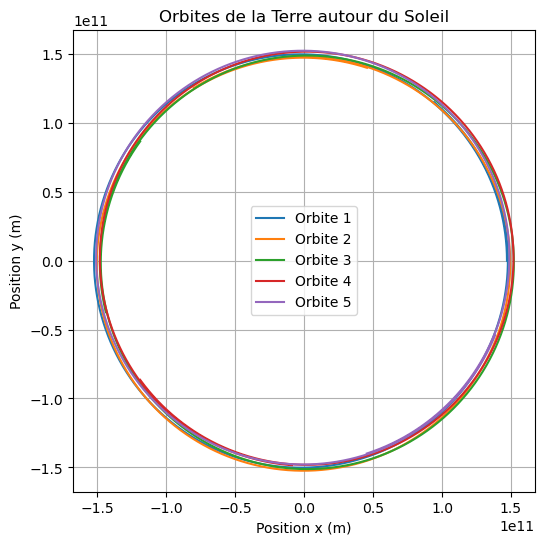

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const

# Constantes
G = const.G.value  # Constante gravitationnelle
M = const.M_sun.value  # Masse du Soleil

# Fonction d'accélération
def acceleration(r):
    return -G * M * r / np.linalg.norm(r)**3

# Méthode de Verlet
def verlet_method(r0, v0, dt, steps):
    r = r0
    v = v0
    positions = [r0]
    
    for _ in range(steps):
        k = acceleration(r)
        r_half = r + 0.5 * v * dt
        v_new = v + k * dt
        r_new = r_half + 0.5 * v_new * dt
        positions.append(r_new)
        r = r_new
        v = v_new
        
    return np.array(positions)

# Paramètres de simulation
dt = 3600  # 1 heure en secondes
num_steps = 10000  # Nombre de pas de temps

# Conditions initiales pour différentes orbites
r_perihelion = 1.4710e11  # m
v_perihelion = 3.0287e4  # m/s
num_orbits = 5  # Nombre d'orbites à tracer

# Plot de plusieurs orbites
plt.figure(figsize=(8, 6))
for i in range(num_orbits):
    # Décalage de l'angle initial pour chaque orbite
    theta_shift = 2 * np.pi * i / num_orbits
    # Conditions initiales pour cette orbite
    r0 = np.array([r_perihelion * np.cos(theta_shift), r_perihelion * np.sin(theta_shift)])
    v0 = np.array([-v_perihelion * np.sin(theta_shift), v_perihelion * np.cos(theta_shift)])
    # Calcul de l'orbite
    orbit = verlet_method(r0, v0, dt, num_steps)
    # Plot de l'orbite
    plt.plot(orbit[:, 0], orbit[:, 1], label=f'Orbite {i+1}')

plt.xlabel('Position x (m)')
plt.ylabel('Position y (m)')
plt.title('Orbites de la Terre autour du Soleil')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.legend()
plt.show()

### b)

Modifiez votre programme pour qu’il calcule aussi l’énergie potentielle $-GMm/r$ et
cinétique $\frac{1}{2}mv^2$ à chaque pas, ainsi que la somme (énergie totale) de ces deux quantitées.
Rapportez ces valeurs en fonction du temps dans un graphique et commentez.

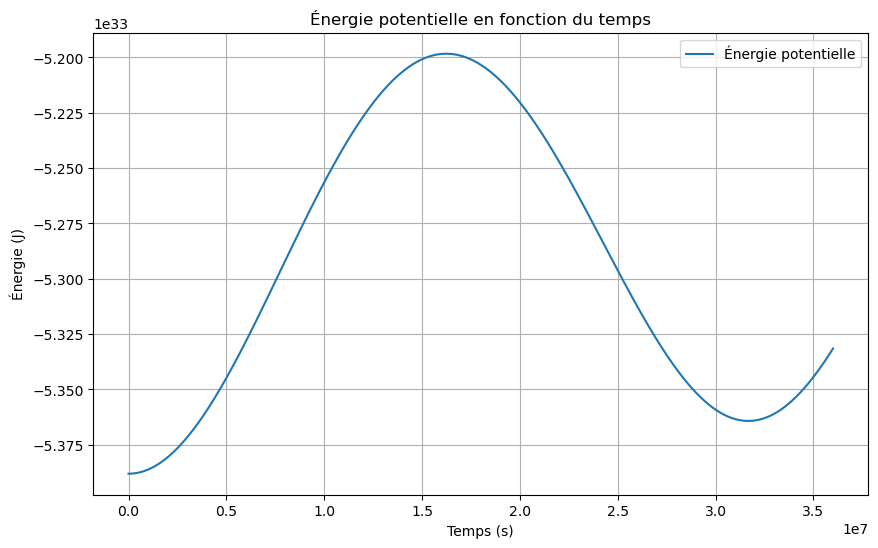

In [6]:
# Calcul de l'énergie potentielle
def potential_energy(r):
    return -G * M * m / np.linalg.norm(r)

# Calcul de l'orbite et des énergies
orbit, potential_energy_values, kinetic_energy_values, total_energy_values = verlet_method(r0, v0, dt, num_steps)

# Plot des énergies en fonction du temps
plt.figure(figsize=(10, 6))
plt.plot(time_values, potential_energy_values, label='Énergie potentielle')
plt.xlabel('Temps (s)')
plt.ylabel('Énergie (J)')
plt.title('Énergie potentielle en fonction du temps')
plt.legend()
plt.grid(True)
plt.show()

## TP3.2 Mécanique céleste - Mars